In this notebook, I search for ideal wavelengths with which we can generate lightcurves.

**Still need to perform this analysis on new Venus data**

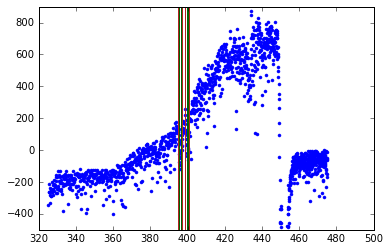

In [198]:
# wide
plt.plot(wlen,rflux[300],'.')
plt.xlim(320,500)
plt.ylim(-500,900)
plt.plot([395.6]*2,[-5000,5000],'darkgreen')
plt.plot([396.4]*2,[-5000,5000],'darkgreen')

plt.plot([395.0]*2,[-5000,5000],'firebrick')
plt.plot([397.0]*2,[-5000,5000],'firebrick')

plt.plot([399.5]*2,[-5000,5000],'darkgreen')
plt.plot([400.3]*2,[-5000,5000],'darkgreen')

plt.plot([398.9]*2,[-5000,5000],'firebrick')
plt.plot([400.9]*2,[-5000,5000],'firebrick')

plt.show()

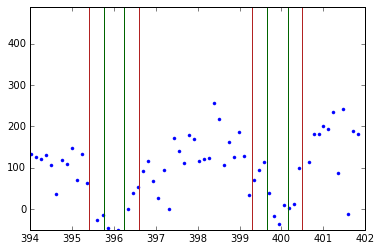

In [190]:
# narrow
plt.plot(wlen,rflux[300],'.')
plt.xlim(394,402)
plt.ylim(-50,490)
plt.plot([395.4]*2,[-5000,5000],'firebrick')
plt.plot([396.6]*2,[-5000,5000],'firebrick')

plt.plot([395.75]*2,[-5000,5000],'darkgreen')
plt.plot([396.25]*2,[-5000,5000],'darkgreen')

plt.plot([399.3]*2,[-5000,5000],'firebrick')
plt.plot([400.5]*2,[-5000,5000],'firebrick')

plt.plot([399.65]*2,[-5000,5000],'darkgreen')
plt.plot([400.15]*2,[-5000,5000],'darkgreen')

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pan
from glob import glob
%matplotlib inline

In [27]:
# Extracts times, wavelengths, and fluxes from raw data files
def get_data(filename):
    # Open the first file and read the first two lines
    f = open(filename,'r')
    line1 = f.readline()
    line2 = f.readline()
    f.close()
    wlen = np.genfromtxt(filename,delimiter=',',skip_header=2,max_rows=1)[1:]
    
    # Pull starting time from first line & save as float
    hour = float(line1[21:23])
    minute = float(line1[24:26])
    second = float(line1[27:])
    start_time = hour + minute/60 + second/3600
    
    # Reads the rest of the data
    dat = np.genfromtxt(filename,skip_header=3,delimiter=',')
    
    # Saves time and flux data
    time = dat[:,0]/3600+start_time
    allflux = dat[:,1:]
    return wlen,allflux,time

In [200]:
# Creates lightcurve from data
def get_lightcurve(wlen,data,date='wide',emission_line='K'):
    # BEFORE 5/7
    if date == 'wide':
        if emission_line == 'K':
            min_targ = 395.6
            max_targ = 396.4
            min_comp = 395
            max_comp = 397
        elif emission_line == 'H':
            min_targ = 399.5
            max_targ = 400.3
            min_comp = 398.9
            max_comp = 400.9

    # AFTER 5/7
    elif date == 'narrow':
        if emission_line == 'K':
            min_targ = 395.75
            max_targ = 396.25
            min_comp = 395.4
            max_comp = 396.6

        elif emission_line == 'H':
            min_targ = 399.65
            max_targ = 400.15
            min_comp = 399.3
            max_comp = 400.5

    target_wavelengths = np.where((wlen > min_targ)&(wlen < max_targ))[0]
    comparison_wavelengths = np.where(((wlen > min_comp)&(wlen < min_targ))|
                                      ((wlen > max_targ)&(wlen < max_comp)))[0]
    most_wavelengths = np.where((wlen > 380)&(wlen < 440))[0]
    target_flux = [np.mean(i) for i in data[:,target_wavelengths]]
    comparison_flux = [np.mean(i) for i in data[:,comparison_wavelengths]]
    all_flux = [np.mean(i) for i in data[:,most_wavelengths]]
    return target_flux,comparison_flux,all_flux

In [203]:
dark_wlen,darkflux,darktime = get_data('../venus_data/20180605/dark7s_1.dat')
wlen,allflux,time = get_data('../venus_data/20180606/venus_1.dat')
avdflux = np.mean(darkflux[1:],axis=0)
rflux = [np.subtract(i,avdflux) for i in allflux]

In [204]:
flux,comp_flux,most_flux = get_lightcurve(wlen,np.array(rflux),date='wide',emission_line='K')

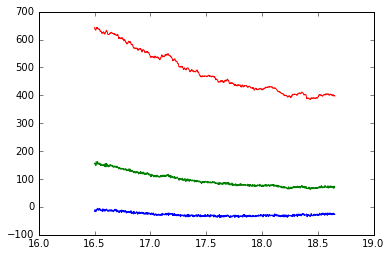

In [205]:
plt.plot(time[1:],flux[1:])
plt.plot(time[1:],comp_flux[1:])
plt.plot(time[1:],most_flux[1:])
plt.show()

In [188]:
flux,comp_flux = get_lightcurve(wlen,np.array(rflux),date='narrow',emission_line='K')

//anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
//anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


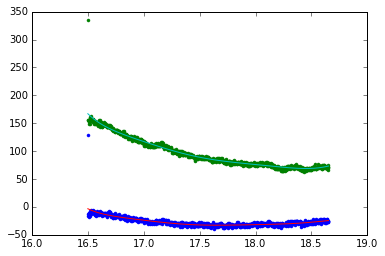

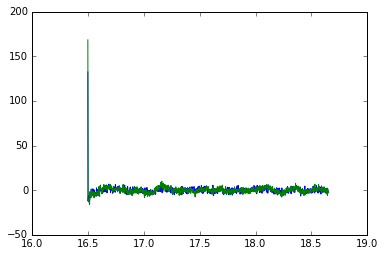

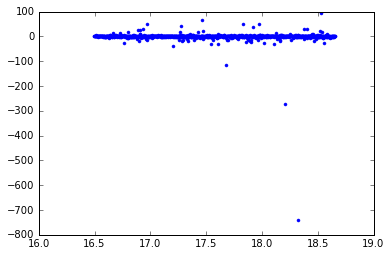

In [207]:
# Fit resulting light curve to polynomial
a=np.polyfit(time,flux,10)
b=np.poly1d(a)
# Divide light curve by fitted polynomial
pflux = np.subtract(flux,b(time))

# Fit resulting light curve to polynomial
aa=np.polyfit(time,comp_flux,10)
bb=np.poly1d(aa)
# Divide light curve by fitted polynomial
comp_pflux = np.subtract(comp_flux,bb(time))

plt.plot(time,flux,'.')
plt.plot(time,comp_flux,'.')
plt.plot(time,b(time))
plt.plot(time,bb(time))
plt.show()

plt.plot(time,pflux)
plt.plot(time,comp_pflux)
plt.show()

plt.plot(time,np.divide(pflux,comp_pflux),'.')

In [4]:
def polyreduce(obs,flux,comp_flux,ot):
    # Fit resulting light curve to polynomial
    a=np.polyfit(obs,flux,100)
    b=np.poly1d(a)
    # Divide light curve by fitted polynomial
    pflux = np.divide(flux,b(obs))-1

    # Fit resulting light curve to polynomial
    aa=np.polyfit(obs,comp_flux,100)
    bb=np.poly1d(aa)
    # Divide light curve by fitted polynomial
    comp_pflux = np.divide(comp_flux,bb(obs))-1

    plt.plot(obs,flux,'.')
    plt.plot(obs,comp_flux,'.')
    plt.plot(obs,b(obs))
    plt.plot(obs,bb(obs))
    plt.title('Raw Data and Fitted Polynomial: '+ot)
    plt.show()

    plt.plot(obs,pflux,'.',alpha=.7)
    plt.plot(obs,comp_pflux,'.',alpha=.7)
    plt.title('Poly-divided Lightcurves: '+ot)
    plt.show()
    
    
    flat_flux_fun = np.divide(np.add(pflux,1),np.add(comp_pflux,1))
    plt.plot(obs,flat_flux_fun,'.')
    plt.title('Full Dividede Lightcurve: '+ot)
    plt.show()

    h1h = pan.rolling_median(flat_flux_fun,5000)
    '''
    plt.plot(obs,h1h)
    plt.title('Median Combined Observation: '+ot)
    plt.xlabel('Local Time')
    plt.ylabel('Flux')
    plt.show()
    '''
    return obs,flat_flux_fun,h1h